# Typical Set Initialization

Stan's MCMC algorithm warms up with an initial fast adaptation interval with default length of 75 iterations.  In these first 75 iterations, "the chain is allowed to converge towards the typical set", see [Stan documentation, Section Automatic Parameter Tuning](https://mc-stan.org/docs/reference-manual/hmc-algorithm-parameters.html#automatic-parameter-tuning).  This notebook proposes a new initialization scheme which uses on average fewer gradient evaluations within 75 warmup iterations to move nearly the same distance toward the typical set.

During the 75 warm up iterations of the initial fast interval, Stan's dynamic HMC leapfrogs through phase space, numerically integrating a Hamiltonian system of equations and then selects a new point ensuring detailed balance holds.  The leapfrog steps ensure progress toward the typical set, while preserving detailed balance guarantees that the subsequent Markov chain will generate draws from the correct target distribution and thus appropriate means of the draws will approximate expectation values of interest.  Since these warmup iterations are commonly thrown away, this author believes there is an argument against spending the computational resources to preserve detailed balance.

In the most common use case of Stan, the initial 75 warmup iterations are to find the typical set, not to provide information about expectation values.  This notebook explores the efficiency gain, if any, to be had in giving up detailed balance during these initial 75 warmup iterations.  The goal is to trade the asymptotic guarantees of detailed balance for more efficient movement toward the typical set.

Similar to Stan, this initialization scheme 

* initializes parameter values $\theta \in \mathbb{R}^D$ with $U_d(-2, 2)$ draws for $d = 1:D$, such that the log_density and its gradient are finite
* adapts the step size based on the change in the [Hamiltonian](https://mc-stan.org/docs/reference-manual/hamiltonian-monte-carlo.html#the-hamiltonian) from the initial point to the final point reached by leapfrog steps,
* does not adapt the scale of the momentum, the metric,
* limits the maximum number of leapfrog steps within an iteration to $2^{10}$ by default, and
* calculates divergences and aborts trajectories if a divergence is reached before a u-turn occurs.

Different from Stan, this initialization scheme

* ignores detailed balance and simply stop leapfrog steps when a u-turn is reached, and
* the final position upon a u-turn is always accepted (assuming the trajectory did not diverge).

## Algorithm details

**input**: log_density_gradient() for a Stan program, dimension D

**output**: a point in parameter space as close to the typical set as Stan might produce

1. initialize $\theta$ from $U(-2, 2)$
2. initialize step_size
3. sample direction from $U(\{-1, 1\})$
4. for step in 1:75
    * sample momentum from $N(0, I_D)$
    * while n_leapfrog < max_leapfrogs
        * position' = position; momentum' = momentum
        * n_leapfrog += 1
        * position', momentum' = leapfrog(position', momentum', direction * step_size)
        * calculate change in Hamiltonian
        * if divergent: break
        * if u_turn: break
    * update step_size
    * if not divergent: position = position'

In [16]:
from cmdstanpy import CmdStanModel
from initialize import initialize # the proposed intialization procedure
from pathlib import Path

import ot # POT: Python Optimal Transport https://pythonot.github.io/index.html

import bridgestan as bs
bs.set_bridgestan_path(Path.home() / "bridgestan")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [27]:
model = "earnings-earn_height" # typical set is far away
# model = "arma-arma11"
stan_file = Path.home() / "minipdb" / "programs" / model / (model + ".stan")
data_file = Path.home() / "minipdb" / "programs" / model / (model + ".json")

bsm = bs.StanModel(stan_file, data_file)
dim = bsm.param_unc_num()

def ldg(position, gradient):
    ld = -np.inf
    try:
        ld, _ = bsm.log_density_gradient(position, out = gradient)
    except:
        pass
    return ld

In [28]:
M = 1 # number of simulations
steps = 75
degrees_before_cut_off = 75
cut_off = np.cos(degrees_before_cut_off * np.pi / 180)

stan_leapfrogs = np.zeros(M)
new_leapfrogs = np.zeros(M)

stan_params = np.zeros(shape = (M, dim))
new_params = np.zeros(shape = (M, dim))

# q_uturns = np.zeros(M)
p_uturns = np.zeros(M)
# o_uturns = np.zeros(M)
count_p_uturns = {"m_mn": 0, "m_ms": 0, "ms_mn": 0, "mb_mn": 0, "mb_ms": 0}

csm = CmdStanModel(stan_file = stan_file)

for m in range(M):
    rng = np.random.default_rng()
    fit_new = initialize(rng, dim, ldg, cut_off = cut_off)
    new_leapfrogs[m] = np.sum(fit_new["number_leapfrogs"])
    new_params[m, :] = fit_new["position"]
    # q_uturns[m] = fit_new["position_uturn"]
    p_uturns[m] = fit_new["momentum_uturn"]  
    # o_uturns[m] = fit_new["either_uturn"]
    for k in count_p_uturns.keys():
        count_p_uturns[k] += fit_new["count_momentum_uturn"][k]
    
    fit_stan = csm.sample(data = str(data_file),
                          save_warmup = True,
                          iter_sampling = 0,
                          iter_warmup = 100,
                          chains = 1,
                          show_progress = False)
    df_draws = fit_stan.draws_pd(inc_warmup = True)
    stan_leapfrogs[m] = np.sum(df_draws["n_leapfrog__"][:steps])
    l = len(df_draws.columns)
    q = df_draws.iloc[steps, (l - dim):l].values.copy()
    stan_params[m, :] = bsm.param_unconstrain(q)

09:20:45 - cmdstanpy - INFO - CmdStan start processing
09:20:45 - cmdstanpy - INFO - Chain [1] start processing
09:20:45 - cmdstanpy - INFO - Chain [1] done processing


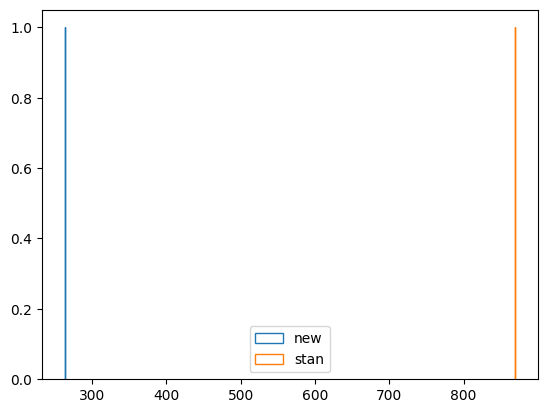

In [29]:
plt.hist(new_leapfrogs, histtype = "step", label = "new")
plt.hist(stan_leapfrogs, histtype = "step", label = "stan")
plt.legend()

In [30]:
mn = np.mean(new_leapfrogs)
ms = np.mean(stan_leapfrogs)
rm = np.round(mn / ms, 2)
print(f"ratio of mean leapfrogs: new / stan = {rm}")

mdn = np.median(new_leapfrogs)
mds = np.median(stan_leapfrogs)
rmd = np.round(mdn / mds, 2)
print(f"ratio of median leapfrogs: new / stan = {rmd}")

vn = np.var(new_leapfrogs)
vs = np.var(stan_leapfrogs)
rv = np.round(vn / vs, 2)
print(f"ratio of variance leapfrogs: new / stan = {rv}")

mnn = np.min(new_leapfrogs) 
mns = np.min(stan_leapfrogs)
rmn = np.round(mnn / mns, 2)
print(f"ratio of minimum leapfrogs: new / stan = {rmn}")

mxn = np.max(new_leapfrogs) 
mxs = np.max(stan_leapfrogs)
rmx = np.round(mxn / mxs, 2)
print(f"ratio of maximum leapfrogs: new / stan = {rmx}")

z = np.array([-1.96, 1.96])
print("confidence interval of difference of mean leapfrogs, new - stan")
np.round((mn - ms) + z * np.sqrt((vn + vs) / M))

ratio of mean leapfrogs: new / stan = 0.3
ratio of median leapfrogs: new / stan = 0.3
ratio of variance leapfrogs: new / stan = nan
ratio of minimum leapfrogs: new / stan = 0.3
ratio of maximum leapfrogs: new / stan = 0.3
confidence interval of difference of mean leapfrogs, new - stan


/var/folders/10/vhgkp_1x0p310y0lw2d5mx8h0000gn/T/ipykernel_65189/2221419576.py:13: RuntimeWarning: invalid value encountered in scalar divide
  rv = np.round(vn / vs, 2)


array([-606., -606.])

In [31]:
print(f"exclusive momentum based uturns: {np.sum(p_uturns)}")
# print(f"exclusive position based uturns: {np.sum(q_uturns)}")
# print(f"momentum and position based uturns: {np.sum(p_uturns) + np.sum(q_uturns) - np.sum(o_uturns)}")
# print(f"momentum or position based uturns: {np.sum(o_uturns)}")

exclusive momentum based uturns: 66.0
exclusive position based uturns: 0.0
momentum and position based uturns: 0.0
momentum or position based uturns: 66.0


In [32]:
count_p_uturns

{'m_mn': 31, 'm_ms': 14, 'ms_mn': 31, 'mb_mn': 59, 'mb_ms': 49}

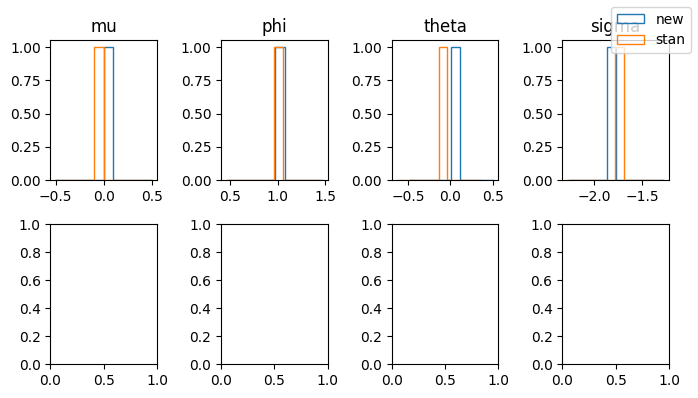

In [34]:
n_cols = 4
n_rows = np.divmod(dim, n_cols)[0] + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize = (7, 4))
md = np.size(np.shape(axs))
param_names = bsm.param_names()

for d in range(dim):
    ir, ic = np.divmod(d, n_cols)
    ax = axs[ic] if md == 1 else axs[ir, ic]
    ax.hist(new_params[:, d], histtype = "step", label = "new" if d == 0 else None)
    ax.hist(stan_params[:, d], histtype = "step", label = "stan" if d == 0 else None)
    ax.title.set_text(param_names[d])
fig.tight_layout()
fig.legend()

In [35]:
evs = {
    "mean_new": np.mean(new_params, axis = 0),
    "mean_stan": np.mean(stan_params, axis = 0),
    
    "std_new": np.std(new_params, axis = 0),
    "st_stan": np.std(stan_params, axis = 0),
    
    "q05_new": np.quantile(new_params, 0.05, axis = 0),
    "q05_stan": np.quantile(stan_params, 0.05, axis = 0),
    
    "q25_new": np.quantile(new_params, 0.25, axis = 0),
    "q25_stan": np.quantile(stan_params, 0.25, axis = 0),

    "q50_new": np.quantile(new_params, 0.5, axis = 0),
    "q50_stan": np.quantile(stan_params, 0.5, axis = 0),

    "q75_new": np.quantile(new_params, 0.75, axis = 0),
    "q75_stan": np.quantile(stan_params, 0.75, axis = 0),

    "q95_new": np.quantile(new_params, 0.95, axis = 0),
    "q95_stan": np.quantile(stan_params, 0.95, axis = 0),
}
np.round(pd.DataFrame.from_dict(evs), 2)

,mean_new,mean_stan,std_new,st_stan,q05_new,q05_stan,q25_new,q25_stan,q50_new,q50_stan,q75_new,q75_stan,q95_new,q95_stan
0,9.93,8.11,110.88,54.25,-197.93,-70.56,-54.17,-24.42,4.19,0.06,83.82,37.08,211.13,105.96
1,342.90,326.02,73.21,61.08,258.29,195.23,332.40,325.25,352.16,345.08,366.01,352.97,396.39,362.15
2,9.90,9.88,0.14,0.05,9.76,9.84,9.84,9.86,9.87,9.87,9.91,9.89,10.18,10.02


In [22]:
# W-1 distance between parameter values for new init and stan init across all simulations
equal_weights = np.ones(M) / M
CM = ot.dist(new_params, stan_params, metric= "euclidean", p = 1)
wn = ot.emd2(equal_weights, equal_weights, CM)
print(f"Wasserstein-1(new_params, stan_params) =  {np.round(wn, 2)}")

Wasserstein-1(new_params, stan_params) =  0.14


In [23]:
# How far did new init scheme move initial draws?
sh = np.shape(stan_params)
U = np.random.uniform(-2, 2, size = sh)
UN = ot.dist(U, new_params, metric = "euclidean", p = 1)
wnu = ot.emd2(equal_weights, equal_weights, UN)
print(f"W-1( U(-2, 2), new_params) = {np.round(wnu, 2)}")

W-1( U(-2, 2), new_params) = 3.95


In [24]:
# How far did Stan init scheme move initial draws?
US = ot.dist(U, stan_params, metric = "euclidean", p = 1)
wsu = ot.emd2(equal_weights, equal_weights, US)
print(f"W-1( U(-2, 2), stan_params) = {np.round(wsu, 2)}")

W-1( U(-2, 2), stan_params) = 4.02


In [25]:
# what's the relative distance between W-1(new_params, stan_params) and how far Stan 
# moved the initial U(-2, 2)
print(f"W-1(new_params, stan_params) / W-1( U(-2, 2), stan_params): {np.round(wn / wsu, 2)}")

W-1(new_params, stan_params) / W-1( U(-2, 2), stan_params): 0.04


In [13]:
fit_new

{'position': array([-0.0029824 ,  0.97364777,  0.0090941 , -1.77090532]),
 'number_leapfrogs': array([ 1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1., 18.,  4.,  3., 33.,
        12.,  6.,  1.,  2.,  2.,  1.,  1.,  1.,  8.,  1.,  1.,  1.,  1.,
         1., 55.,  7.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,
         1.,  2.,  3.,  1.,  1.,  1.,  1.,  2.,  5.,  1.,  1.,  1.,  1.,
         1.,  1.,  4.,  1.,  1.,  1.,  2.,  1.,  2.,  2.,  5.,  1.,  3.,
         7.,  1.,  3.,  1.,  3.,  4.,  5.,  4.,  3.,  4.]),
 'number_divergences': 9,
 'momentum_uturn': 66,
 'position_uturn': 0,
 'either_uturn': 66,
 'step_size': 0.013572899714700586,
 'count_momentum_uturn': {'m_mn': 31,
  'm_ms': 14,
  'ms_mn': 31,
  'mb_mn': 59,
  'mb_ms': 49}}

In [21]:
def rand_binomial(K, p, size):
    K = 10
    x = -np.ones(size)
    for s in range(size):
        S = 0.0
        while S <= N:
            g = np.ceil(np.log(np.random.uniform()) / np.log(0.25))
            S += g
            x[s] += 1
    return x

In [25]:
x = rand_binomial(10, 0.75, 100_000)

7.50557

In [28]:
np.median(x)

8.0

In [27]:
10 * 0.75 * 0.25

1.875